### Import Libraries

In [1]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

### Load Dataset

In [3]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

### Defining Global Variables

In [4]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

### Data Pre-processing

In [5]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [6]:
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [7]:
sentences, labels = parse_data_from_file("./bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


### Data Splitting

In [8]:
def train_val_split(sentences, labels, training_split):
    train_size = int(len(sentences) * training_split)

    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [9]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


### Tokenization, Sequences, and Padding

In [10]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [11]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


In [12]:
# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=120)
    
    return padded_sequences

In [13]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


In [14]:
def tokenize_labels(all_labels, split_labels):    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq)-1
    
    return label_seq_np

In [15]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



### Model Building

In [16]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
        
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [18]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

history = model.fit(train_padded_seq, train_label_seq, epochs=100,
                    validation_data=(val_padded_seq, val_label_seq),
                    callbacks=[callback])

Epoch 1/100
56/56 [==============================] - 1s 6ms/step - loss: 1.5995 - accuracy: 0.2567 - val_loss: 1.5854 - val_accuracy: 0.4472 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 0s 4ms/step - loss: 1.5559 - accuracy: 0.4169 - val_loss: 1.5176 - val_accuracy: 0.4382 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 0s 4ms/step - loss: 1.4388 - accuracy: 0.5028 - val_loss: 1.3589 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 0s 4ms/step - loss: 1.2207 - accuracy: 0.6404 - val_loss: 1.1154 - val_accuracy: 0.7079 - lr: 0.0010
Epoch 5/100
56/56 [==============================] - 0s 4ms/step - loss: 0.9517 - accuracy: 0.7747 - val_loss: 0.8664 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 6/100
56/56 [==============================] - 0s 4ms/step - loss: 0.7035 - accuracy: 0.8826 - val_loss: 0.6579 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 7/100
56/56 [==============================] - 0s 4ms/step - loss: 0.5

### Model Evaluation

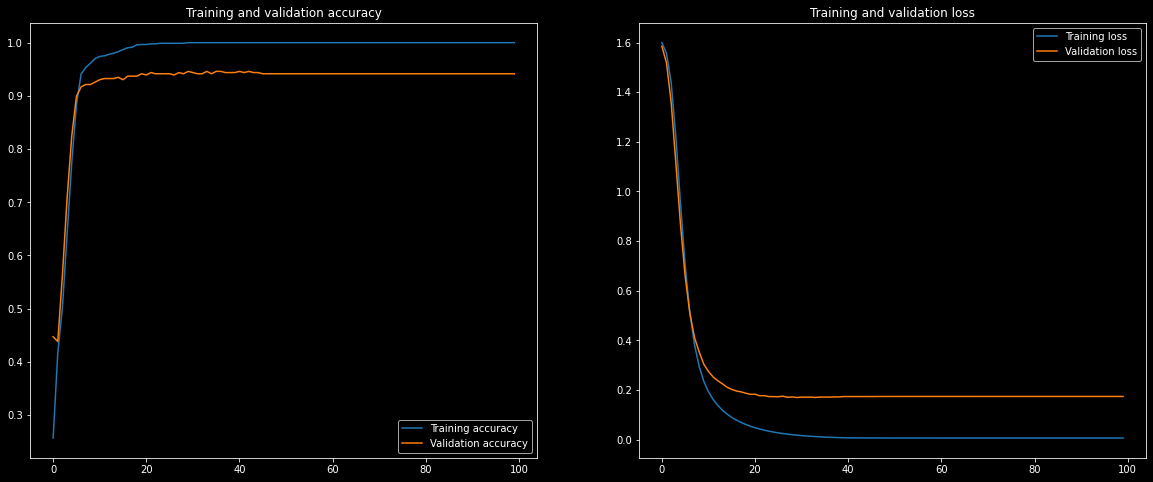

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)

### 3D Word Embedding Visualization

In [26]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


In [27]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

### Visualization at [Embedding Projector](https://projector.tensorflow.org/)